## Potential Data
- Unemployment data
- Consumer sentiment data
- Bank interest rate
- Mortgage interest rate
- Consumer credit scores
- Corporate earnings or EPS
- Unemployment claims
- Vix or other volatility indicator

# Generate these files:
- National metrics at monthly intervals
- National metrics at weekly intervals
- Local metrics at monthly intervals
- Local metrics at weekly intervals

In [227]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
% matplotlib inline

import sys, os, copy
print("Using environment in "+sys.prefix)
print("Python version "+sys.version)


Using environment in /Users/emunsing/Documents/Coding/github/cdips_hpi_forecast/env
Python version 3.5.2 (default, Oct 31 2016, 16:50:28) 
[GCC 4.2.1 Compatible Apple LLVM 7.3.0 (clang-703.0.31)]


In [248]:
cityList = ['Dallas', 'Atlanta','Phoenix','Vegas']
nationalMonthly = pd.DataFrame()
nationalWeekly = pd.DataFrame()
metroMonthly = {city:pd.DataFrame() for city in cityList}  # Create a dictionary of DataFrames for storing the city-specific data
metroWeekly = {city:pd.DataFrame() for city in cityList}  # Create a dictionary of DataFrames for storing the city-specific data


## Regional Unemployment Data And Labor Force

From [Bureau of Labor Statistics seasonally adjusted unemployment data](https://www.bls.gov/lau/metrossa.htm)


In [249]:
metroString = {'Dallas' : 'Dallas-Fort Worth-Arlington, TX MSA',
               'Atlanta': 'Atlanta-Sandy Springs-Roswell, GA MSA',
               'Phoenix': 'Phoenix-Mesa-Scottsdale, AZ MSA',
               'Vegas'  : 'Las Vegas-Henderson-Paradise, NV MSA'}

df = pd.read_excel('Data/Unemployment/ssamatab1.xlsx',header=2,parse_dates=[['Year','Month']])
df.dropna(inplace=True)
df.index = pd.DatetimeIndex(df['Year_Month'])
del df.index.name
df['unemployRate'] = df['Unemployment']/df['Civilian Labor Force'] * 100  # This gives us more significant digits

for city in metroString.keys():
    cityData = df[df['Area']==metroString[city]]
    metroMonthly[city]['metroUnemployment'] = cityData['unemployRate']
    metroMonthly[city]['metroLaborForce']   = cityData['Civilian Labor Force']

# National Consumer Sentiment Index (U. of Michigan)

In [250]:
df = pd.read_excel('Data/consumer_sentiment/UMCSI.xls',header=3,parse_dates=[[0,1]]).dropna()  # Dates are in columns 0 and 1
df.index = pd.DatetimeIndex(df[df.columns[0]])
del df.index.name
nationalMonthly['csi'] = df['CURRENT INDEX']

# National Consumer Price Index (Bureau of Labor Statistics)

In [251]:
# Expects tabular data with columns for each month and for 'HALF1','HALF2'
# Need to pivot/stack data to be able to get values in a Series, then create date

df = pd.read_excel('Data/ConsumerPriceIndex/CPI.xlsx',header=11).drop(['HALF1','HALF2'],axis=1)
df = df.set_index('Year',drop=True)
df = df.stack()
df.index.rename(['Year','Month'],inplace=True)
df = df.reset_index()
df.index = pd.DatetimeIndex(pd.to_datetime(df['Month'].astype(str) + ' ' + df['Year'].astype(str)))
nationalMonthly['cpi'] = df[0]

# Weekly Unemployment claims - National and State
"Covered Employment" (size of labor pool) is updated quarterly

In [266]:
### NATIONAL-LEVEL WEEKLY UNEMPLOYMENT CLAIMS- SEASONALLY ADJUSTED!

df = pd.read_excel('Data/Unemployment/WeeklyClaims/NationalWeeklyClaims.xlsx',header=[1,2])
df = df.iloc[:-2,:]  # This gets rid of the blank line and "Run date" line
df.index = pd.DatetimeIndex(df.index)

nationalWeekly['natInitialUnemployment']   = df.loc[:,('Initial Claims',  'S.A.')]
nationalWeekly['natInitialUnemployment4wk']= df.loc[:,('Initial Claims',  'S.A. 4-Week')]
nationalWeekly['natContUnemployment']      = df.loc[:,('Continued Claims','S.A.')]
nationalWeekly['natContUnemployment4wk']   = df.loc[:,('Continued Claims','S.A. 4-Week')]

coveredEmployment = df.loc[:,('Covered Employment','Unnamed: 10_level_1')]
coveredEmployment = coveredEmployment.resample('QS').mean()
nationalMonthly['natLaborForce'] = coveredEmployment.resample('MS').interpolate()
nationalMonthly['natInitialUnemployment'] = nationalWeekly['natInitialUnemployment4wk'].resample('MS').sum()
nationalMonthly['natInitialUnemployment4wk'] = nationalWeekly['natInitialUnemployment4wk'].resample('MS').sum()
nationalMonthly['natContUnemployment'] = nationalWeekly['natContUnemployment'].resample('MS').sum()
nationalMonthly['natContUnemployment4wk'] = nationalWeekly['natContUnemployment4wk'].resample('MS').sum()

### STATE-LEVEL  UNEMPLOYMENT DATA : NOT SEASONALLY ADJUSTED!!!
stateDict   = {'Dallas' : 'Texas',
               'Atlanta': 'Georgia',
               'Phoenix': 'Arizona',
               'Vegas'  : 'Nevada'}

df = pd.read_excel('Data/Unemployment/WeeklyClaims/StateWeeklyClaims.xlsx', header=4)
df = df.iloc[:-2,:]  # This gets rid of the blank line and "Run date" line
df.index = pd.DatetimeIndex(df['Reflecting Week Ended'])
del df.index.name

# Parse the data for each city
for city in cityList:
    state = stateDict[city]
    # Keep state unemployment at the weekly level
    stateDf = df[df['State']==state]
    metroWeekly[city]['stateInitialUnemplClaims']   = stateDf['Initial Claims']
    metroWeekly[city]['stateContinuedUnemplClaims'] = stateDf['Continued Claims']
    metroMonthly[city]['stateInitialUnemplClaims']  = stateDf['Initial Claims'].resample('MS').sum()
    metroMonthly[city]['stateContinuedUnemplClaims']= stateDf['Continued Claims'].resample('MS').sum()

    # Total labor force is computed quarterly; need to resample and interpolate
    coveredEmployment = stateDf['Covered Employment']
    coveredEmployment = coveredEmployment.resample('QS').mean()
    metroMonthly[city]['stateLaborForce'] = coveredEmployment.resample('MS').interpolate().round()

# Mortgage Interest Rates

In [194]:
import pandas_datareader.data as web
import datetime
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime.today()

In [197]:
df = web.DataReader("MORTGAGE30US", "fred", start, end)

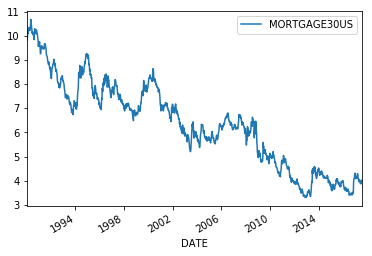

In [203]:
df.plot()

# New approach

In [ ]:
### Fred Quarterly data:
"DRSFRMACBS",""

# Zillow Data

In [253]:
# Monthly data
inputFiles = {'inventoryAge': 'AgeOfInventory_Metro_Public.csv',  # Available after Q1 2010. Drop "RegionType	StateFullName	DataTypeDescription"
              'daysOnZillow': 'DaysOnZillow_Public_Metro.csv',  # After 2010-01. Drop "StateName	RegionType	CBSA Title	SizeRank"
              'inventory'   : 'InventoryMeasure_SSA_Metro_Public.csv', #After 2010-01; smoothed & seasonally adjusted. drop "RegionType" "StateFullName" "DataTypeDescription"
              'foreclosures': 'Metro_HomesSoldAsForeclosures-Ratio_AllHomes.csv', # After 1998
              'pricecut'    : 'Metro_Listings_PriceCut_SeasAdj_AllHomes.csv', # After 2010-09
              'sold4Gain'   : 'Metro_PctOfHomesSellingForGain_AllHomes.csv', # After 2001-01  (2012 for Phoenix)
              'sold4Loss'   : 'Metro_PctOfHomesSellingForLoss_AllHomes.csv', # After 2001-01  (2012 for Phoenix)
              'price2rent'  : 'Metro_PriceToRentRatio_AllHomes.csv',  # After 2010-10
              'rentAllHomes': 'Metro_Zri_AllHomes.csv', # After 2010-11
              'rentMultifam': 'Metro_Zri_MultiFamilyResidenceRental.csv', #After 2010-11
              'rentSFR'     : 'Metro_Zri_SingleFamilyResidenceRental.csv' #After 2010-11
             }

#  Map Zillow RegionID to metro area string
metroRegionID = {'Dallas-Fort Worth, TX':394514,
                     'Atlanta, GA':394347,
                     'Phoenix, AZ':394976,
                     'Las Vegas, NV':394775 }

metroString = {'Dallas':u'Dallas-Fort Worth, TX',
               'Atlanta':u'Atlanta, GA',
               'Phoenix':u'Phoenix, AZ',
               'Vegas':u'Las Vegas, NV'}

dropCols = ['RegionID','RegionType','SizeRank','StateFullName','DataTypeDescription','StateName','RegionType','CBSA Title']

startDate = None
endDate = None

for fname in inputFiles.keys():
    # Read data into a temporary data file, then pull out the city and time period which we want.
    df = pd.read_csv('Data/ZHVI/'+inputFiles[fname])
    df.set_index('RegionName',drop=True,inplace=True)
    df = df.drop(dropCols,axis=1,errors='ignore')
    df.columns = pd.DatetimeIndex(df.columns)
    
    for city in metroString.keys():
        try:
            metroMonthly[city][fname] = df.loc[ metroString[city],startDate:endDate]  # Note: Atlanta doesn't have foreclosure data
        except KeyError:
            pass

# Quarterly data- currently just income
df = pd.read_csv('Data/ZHVI/Affordability_Income_2017Q1.csv')
df.set_index('RegionName',drop=True,inplace=True)
df.drop(dropCols,axis=1,errors='ignore',inplace=True)
df.columns = pd.DatetimeIndex(df.columns)
df = df.T.resample('MS').interpolate().T   # Interpolation only works along rows!

for city in metroString.keys():
    metroMonthly[city]['metroIncome'] = df.loc[metroString[city],startDate:endDate]


In [262]:
metroMonthly['Phoenix'].tail()

,metroUnemployment,metroLaborForce,stateInitialUnemplClaims,stateContinuedUnemplClaims,stateLaborForce,pricecut,inventory,foreclosures,sold4Loss,rentMultifam,price2rent,rentSFR,rentAllHomes,inventoryAge,sold4Gain,daysOnZillow,metroIncome
2017-01-01,4.372032,2280244.0,17126.0,103441.0,2644857.0,17.951161,20996.0,1.1361,14.19,1169.0,14.51,1348.0,1325.0,71.0,85.81,76.50,57850.748928
2017-02-01,4.505980,2302385.0,14926.0,102187.0,2651409.0,18.289892,21224.0,1.0924,14.51,1167.0,14.53,1350.0,1325.0,62.0,85.49,75.25,57982.201923
2017-03-01,4.301741,2311111.0,16031.0,98029.0,2657960.0,18.797798,21545.0,1.0691,13.67,1164.0,14.58,1352.0,1326.0,54.0,86.33,68.75,58113.654917
2017-04-01,4.214475,2304415.0,27341.0,137549.0,2664512.0,18.363505,21601.0,0.7429,13.25,1162.0,14.55,1353.0,1327.0,48.0,86.75,65.00,NaN
2017-05-01,4.488021,2298051.0,17453.0,118559.0,2669723.0,19.340071,21298.0,0.4268,13.11,1164.0,14.53,1357.0,1331.0,48.0,86.89,64.00,NaN


# Dump the data to file

In [263]:
#### DUMP ALL THE DATA
import pickle

# Master file, as dictionary of dataframes
pickle.dump(metroMonthly,open('Data/Summary/metroMonthly.pkl','wb'))

# Dump the dataframes for each of the cities
for city in cityList:
    pickle.dump(metroMonthly[city],open('Data/Summary/'+city+'Monthly.pkl','wb'))
    
pickle.dump(nationalMonthly,open('Data/Summary/nationalMonthly.pkl','wb'))

In [257]:
# Example of how to load the data
a = pickle.load(open('Data/Summary/nationalMonthly.pkl','rb'))
a.tail()

,csi,cpi,natLaborForce
2017-02-01,111.5,243.603,1.391220e+08
2017-03-01,113.2,243.801,1.393138e+08
2017-04-01,112.7,244.524,1.395056e+08
2017-05-01,111.7,244.733,1.395056e+08
2017-06-01,112.5,244.955,1.395056e+08
